In [1]:
import sys
from pathlib import Path
# Get the repository root (1 levels up from current notebook)
repo_root = Path(__file__).parent.parent if '__file__' in globals() else Path.cwd().parent
sys.path.insert(0, str(repo_root))

# import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, mean_absolute_error, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
import Template
# Definición de modulos
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling  import SMOTE, ADASYN
from sklearn.decomposition import PCA

# Instantiate the Template class
Template = Template.Template()

# Build the path to the Excel file in the repository root
data_path = os.path.join(repo_root, 'Cleaned_Resumen_datos_completos_Rev_final.xlsx')
# import the data from all sheets of the Excel file


df0, df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12, df13, df14, df15 = [
    pd.read_excel(data_path, sheet_name=i) for i in range(16)
]

In [2]:
# Search for NaN values in each dataframe and remove them
dataframes = [df0, df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12, df13, df14, df15]

for i, df in enumerate(dataframes):
    nan_count = df.isna().sum().sum()
    if nan_count > 0:
        print(f"\ndf{i} - Found {nan_count} NaN values:")
        # Show where NaNs are located
        nan_locations = df.isna().sum()
        nan_cols = nan_locations[nan_locations > 0]
        print(nan_cols)
        
        # Show rows with NaN values
        rows_with_nan = df[df.isna().any(axis=1)]
        print(f"Rows with NaN: {rows_with_nan.index.tolist()}")
        
        # Remove rows with NaN values
        dataframes[i] = df.dropna()
        print(f"Shape before: {df.shape}, Shape after: {dataframes[i].shape}")
    else:
        print(f"df{i} - No NaN values found")

# Update the original dataframe variables
df0, df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12, df13, df14, df15 = dataframes

print("\n NaN values removed from all dataframes")

df0 - No NaN values found
df1 - No NaN values found
df2 - No NaN values found
df3 - No NaN values found

df4 - Found 2 NaN values:
Tratamiento    1
Planta         1
dtype: int64
Rows with NaN: [118]
Shape before: (119, 2153), Shape after: (118, 2153)
df5 - No NaN values found
df6 - No NaN values found
df7 - No NaN values found
df8 - No NaN values found

df9 - Found 2151 NaN values:
350     1
351     1
352     1
353     1
354     1
       ..
2496    1
2497    1
2498    1
2499    1
2500    1
Length: 2151, dtype: int64
Rows with NaN: [59]
Shape before: (120, 2153), Shape after: (119, 2153)

df10 - Found 4 NaN values:
Tratamiento    2
Planta         2
dtype: int64
Rows with NaN: [104, 105]
Shape before: (106, 2153), Shape after: (104, 2153)
df11 - No NaN values found

df12 - Found 2 NaN values:
Tratamiento    1
Planta         1
dtype: int64
Rows with NaN: [54]
Shape before: (110, 2153), Shape after: (109, 2153)
df13 - No NaN values found
df14 - No NaN values found
df15 - No NaN values foun

## Reference wavelengths for Relative Change Models

In [3]:
RefDf = df0[(df0['Tratamiento'] == 'Control')]

# Extract the relevant columns (from column 2 onwards)
data_cols = RefDf.iloc[:, 2:]

# The reference value is the mean of RefDf for each wavelength
REF = data_cols.mean()

REF.head()

350    0.062436
351    0.062431
352    0.059371
353    0.060901
354    0.062268
dtype: float64

## Data Preparation

In [4]:
# Concatenate all dataframes into a single dataframe
df_concatenation = pd.concat([df0, df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12, df13, df14, df15], ignore_index=True)

# Calculate the Relative Change for each measurement
data_cols_all = df_concatenation.iloc[:, 2:]
Rel_Change = abs(data_cols_all - REF) / REF

# Combine the Relative Change data with the original identifiers
df_rel_change = pd.concat([df_concatenation.iloc[:, :2], Rel_Change], axis=1)

df_rel_change.head()

,Tratamiento,Planta,350,351,352,353,354,355,356,357,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
0,Control,1.0,0.022518,0.032636,0.101520,0.101225,0.081984,0.082106,0.121750,0.172535,...,0.075817,0.076619,0.079026,0.079278,0.076333,0.075750,0.075781,0.076133,0.077482,0.077510
1,Control,2.0,0.025833,0.024377,0.056521,0.068073,0.068929,0.072732,0.089443,0.089647,...,0.099023,0.100492,0.102458,0.102863,0.104158,0.103526,0.099693,0.099011,0.099738,0.099352
2,Control,3.0,0.043146,0.037132,0.034556,0.026608,0.040571,0.063235,0.057025,0.055254,...,0.132612,0.134329,0.139416,0.140613,0.140499,0.139901,0.136153,0.135587,0.136668,0.136590
3,Control,4.0,0.217423,0.245589,0.250712,0.189834,0.153635,0.169587,0.225166,0.261774,...,0.189041,0.189251,0.188514,0.189502,0.189476,0.191840,0.198119,0.200484,0.201895,0.202640
4,Control,5.0,0.011521,0.026321,0.033398,0.040665,0.034354,0.031537,0.066529,0.060708,...,0.188972,0.190047,0.188944,0.188655,0.186975,0.186065,0.186263,0.185278,0.182628,0.182229


In [5]:
# get the different treatments
df_rel_change['Tratamiento'].unique()

array(['Control', 'Ralstonia', 'E_Hidrico', 'Ral_EH'], dtype=object)

In [6]:
# aply a lambda to change the label of the treatments, 
# If its control or E_Hidrico make it Abiotic if not make it Biotic

df_rel_change['Stress_Type'] = df_rel_change['Tratamiento'].apply(lambda x: 'Abiotic' if x in ['Control', 'E_Hidrico'] else 'Biotic')

# Add the column Stress_Type to the second position
cols = df_rel_change.columns.tolist()
cols.insert(2, cols.pop(cols.index('Stress_Type')))
df_rel_change = df_rel_change.reindex(columns=cols)


df_rel_change.head()

,Tratamiento,Planta,Stress_Type,350,351,352,353,354,355,356,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
0,Control,1.0,Abiotic,0.022518,0.032636,0.101520,0.101225,0.081984,0.082106,0.121750,...,0.075817,0.076619,0.079026,0.079278,0.076333,0.075750,0.075781,0.076133,0.077482,0.077510
1,Control,2.0,Abiotic,0.025833,0.024377,0.056521,0.068073,0.068929,0.072732,0.089443,...,0.099023,0.100492,0.102458,0.102863,0.104158,0.103526,0.099693,0.099011,0.099738,0.099352
2,Control,3.0,Abiotic,0.043146,0.037132,0.034556,0.026608,0.040571,0.063235,0.057025,...,0.132612,0.134329,0.139416,0.140613,0.140499,0.139901,0.136153,0.135587,0.136668,0.136590
3,Control,4.0,Abiotic,0.217423,0.245589,0.250712,0.189834,0.153635,0.169587,0.225166,...,0.189041,0.189251,0.188514,0.189502,0.189476,0.191840,0.198119,0.200484,0.201895,0.202640
4,Control,5.0,Abiotic,0.011521,0.026321,0.033398,0.040665,0.034354,0.031537,0.066529,...,0.188972,0.190047,0.188944,0.188655,0.186975,0.186065,0.186263,0.185278,0.182628,0.182229


In [7]:
# Take out the test set from df_rel_change by extracting plants with same treatement and same plant number
test_set = df_rel_change[((df_rel_change['Tratamiento'] == 'Control') & (df_rel_change['Planta'] == 3)) |
                         ((df_rel_change['Tratamiento'] == 'E_Hidrico') & (df_rel_change['Planta'] == 3)) |
                         ((df_rel_change['Tratamiento'] == 'Ralstonia') & (df_rel_change['Planta'] == 2)) |
                         ((df_rel_change['Tratamiento'] == 'Ral_EH') & (df_rel_change['Planta'] == 2))]

# Remove the test set from the main dataframe
df_rel_change = df_rel_change.drop(test_set.index)  

## Models for Relative Change

In [8]:
# Prepare data for classification
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(df_rel_change['Stress_Type'])
y_test_encoded = le.transform(test_set['Stress_Type'])

# Features (wavelengths only)
X_train = df_rel_change.iloc[:, 3:].values
X_test = test_set.iloc[:, 3:].values

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Class distribution (train):\n{df_rel_change['Stress_Type'].value_counts()}")
print(f"\nClass distribution (test):\n{test_set['Stress_Type'].value_counts()}")

Training set shape: (1669, 2151)
Test set shape: (59, 2151)
Class distribution (train):
Stress_Type
Abiotic    849
Biotic     820
Name: count, dtype: int64

Class distribution (test):
Stress_Type
Abiotic    30
Biotic     29
Name: count, dtype: int64


### Model 1: Logistic Regression with PCA (Best baseline)

In [9]:

param_grid_lr = [
    # L1 regularization
    {
        'pca__n_components': [5, 10, 15, 20, 30, 50],
        'model__penalty': ['l1'],
        'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'model__solver': ['liblinear', 'saga'],
        'model__class_weight': [None, 'balanced']
    },
    # L2 regularization
    {
        'pca__n_components': [5, 10, 15, 20, 30, 50],
        'model__penalty': ['l2'],
        'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'model__solver': ['liblinear', 'saga', 'lbfgs'],
        'model__class_weight': [None, 'balanced']
    },
    # Elasticnet
    {
        'pca__n_components': [5, 10, 15, 20, 30, 50],
        'model__penalty': ['elasticnet'],
        'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'model__solver': ['saga'],
        'model__l1_ratio': [0.2, 0.5, 0.8],
        'model__class_weight': [None, 'balanced']
    }
]

pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('model', LogisticRegression(max_iter=2000))
])

grid_search_lr = GridSearchCV(pipeline_lr, param_grid_lr, cv=5, n_jobs=-1, scoring='balanced_accuracy', verbose=1)
grid_search_lr.fit(X_train, y_encoded)

best_lr = grid_search_lr.best_estimator_
y_pred_lr = best_lr.predict(X_test)

print(f"\n{'='*60}")
print("LOGISTIC REGRESSION WITH PCA")
print(f"{'='*60}")
print(f"Best CV Score: {grid_search_lr.best_score_:.4f}")
print(f"Best Parameters: {grid_search_lr.best_params_}")
print(f"\nTest Accuracy: {accuracy_score(y_test_encoded, y_pred_lr):.4f}")
print(f"Test F1 Score: {f1_score(y_test_encoded, y_pred_lr, average='weighted'):.4f}")
print(f"\nClassification Report:\n{classification_report(y_test_encoded, y_pred_lr, target_names=le.classes_)}")

Fitting 5 folds for each of 576 candidates, totalling 2880 fits

LOGISTIC REGRESSION WITH PCA
Best CV Score: 0.7692
Best Parameters: {'model__C': 0.1, 'model__class_weight': 'balanced', 'model__l1_ratio': 0.2, 'model__penalty': 'elasticnet', 'model__solver': 'saga', 'pca__n_components': 50}

Test Accuracy: 0.8136
Test F1 Score: 0.8136

Classification Report:
              precision    recall  f1-score   support

     Abiotic       0.83      0.80      0.81        30
      Biotic       0.80      0.83      0.81        29

    accuracy                           0.81        59
   macro avg       0.81      0.81      0.81        59
weighted avg       0.81      0.81      0.81        59



c:\Users\ricar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


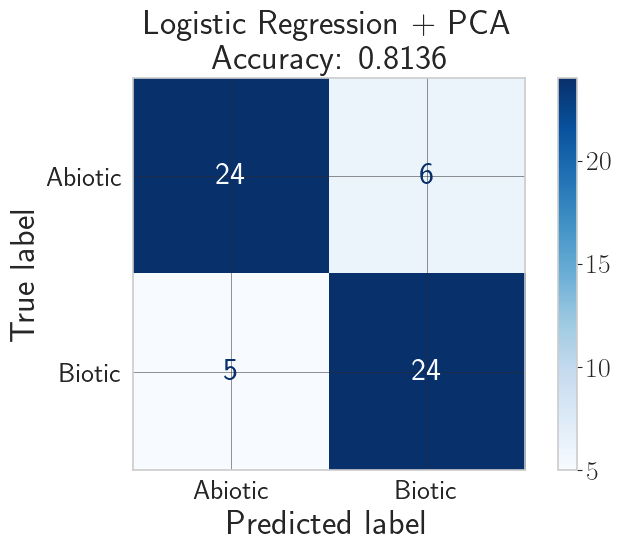

In [10]:
# Confusion Matrix for Logistic Regression
fig, ax = plt.subplots(figsize=(8, 6))
cm_lr = confusion_matrix(y_test_encoded, y_pred_lr)
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=le.classes_)
disp_lr.plot(cmap='Blues', ax=ax)
ax.set_title(f'Logistic Regression + PCA\nAccuracy: {accuracy_score(y_test_encoded, y_pred_lr):.4f}')
plt.tight_layout()
plt.show()

### Model 2: SVM with PCA (Excellent for spectral data)

In [11]:
# Model 2: SVM with PCA
param_grid_svm = {
    'pca__n_components': [10, 20, 30, 50],
    'svm__C': [0.01, 0.1, 1, 10, 100],
    'svm__kernel': ['linear', 'rbf'],
    'svm__gamma': ['scale', 'auto', 0.1],
    'svm__class_weight': ['balanced', None]
}

pipeline_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('svm', SVC())
])

grid_search_svm = GridSearchCV(pipeline_svm, param_grid_svm, cv=5, n_jobs=-1, scoring='balanced_accuracy', verbose=1)
grid_search_svm.fit(X_train, y_encoded)

best_svm = grid_search_svm.best_estimator_
y_pred_svm = best_svm.predict(X_test)

print(f"\n{'='*60}")
print("SVM WITH PCA")
print(f"{'='*60}")
print(f"Best CV Score: {grid_search_svm.best_score_:.4f}")
print(f"Best Parameters: {grid_search_svm.best_params_}")
print(f"\nTest Accuracy: {accuracy_score(y_test_encoded, y_pred_svm):.4f}")
print(f"Test F1 Score: {f1_score(y_test_encoded, y_pred_svm, average='weighted'):.4f}")
print(f"\nClassification Report:\n{classification_report(y_test_encoded, y_pred_svm, target_names=le.classes_)}")

Fitting 5 folds for each of 240 candidates, totalling 1200 fits

SVM WITH PCA
Best CV Score: 0.7715
Best Parameters: {'pca__n_components': 30, 'svm__C': 100, 'svm__class_weight': 'balanced', 'svm__gamma': 0.1, 'svm__kernel': 'linear'}

Test Accuracy: 0.8644
Test F1 Score: 0.8644

Classification Report:
              precision    recall  f1-score   support

     Abiotic       0.87      0.87      0.87        30
      Biotic       0.86      0.86      0.86        29

    accuracy                           0.86        59
   macro avg       0.86      0.86      0.86        59
weighted avg       0.86      0.86      0.86        59



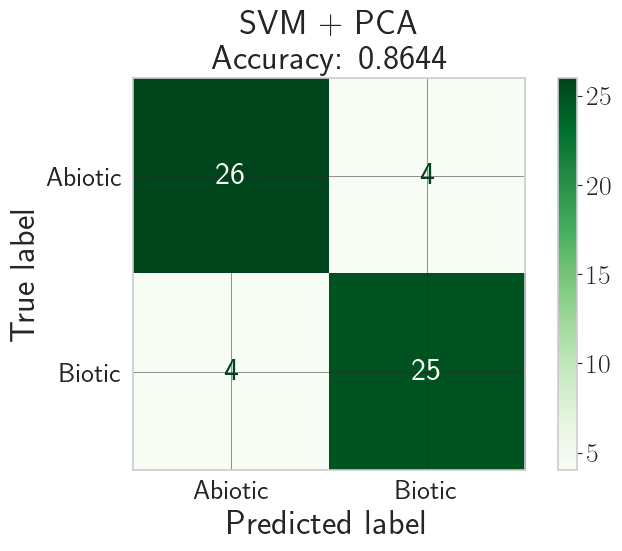

In [12]:
# Confusion Matrix for SVM
fig, ax = plt.subplots(figsize=(8, 6))
cm_svm = confusion_matrix(y_test_encoded, y_pred_svm)
disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=le.classes_)
disp_svm.plot(cmap='Greens', ax=ax)
ax.set_title(f'SVM + PCA\nAccuracy: {accuracy_score(y_test_encoded, y_pred_svm):.4f}')
plt.tight_layout()
plt.show()

### Model 3: Random Forest with PCA (Robust ensemble method)

In [13]:
# Model 3: Random Forest with PCA
param_grid_rf = {
    'pca__n_components': [10, 20, 30, 50, 100],
    'rf__n_estimators': [50, 100, 200, 300],
    'rf__max_depth': [None, 10, 20, 30],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__class_weight': ['balanced', 'balanced_subsample', None]
}

pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('rf', RandomForestClassifier(random_state=42))
])

grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=5, n_jobs=-1, scoring='balanced_accuracy', verbose=1)
grid_search_rf.fit(X_train, y_encoded)

best_rf = grid_search_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)

print(f"\n{'='*60}")
print("RANDOM FOREST WITH PCA")
print(f"{'='*60}")
print(f"Best CV Score: {grid_search_rf.best_score_:.4f}")
print(f"Best Parameters: {grid_search_rf.best_params_}")
print(f"\nTest Accuracy: {accuracy_score(y_test_encoded, y_pred_rf):.4f}")
print(f"Test F1 Score: {f1_score(y_test_encoded, y_pred_rf, average='weighted'):.4f}")
print(f"\nClassification Report:\n{classification_report(y_test_encoded, y_pred_rf, target_names=le.classes_)}")

Fitting 5 folds for each of 2160 candidates, totalling 10800 fits

RANDOM FOREST WITH PCA
Best CV Score: 0.7962
Best Parameters: {'pca__n_components': 30, 'rf__class_weight': None, 'rf__max_depth': 10, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 10, 'rf__n_estimators': 50}

Test Accuracy: 0.8475
Test F1 Score: 0.8475

Classification Report:
              precision    recall  f1-score   support

     Abiotic       0.86      0.83      0.85        30
      Biotic       0.83      0.86      0.85        29

    accuracy                           0.85        59
   macro avg       0.85      0.85      0.85        59
weighted avg       0.85      0.85      0.85        59



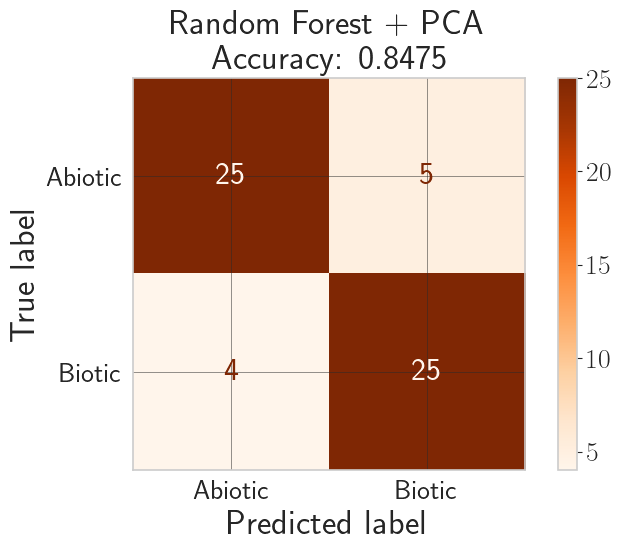

In [14]:
# Confusion Matrix for Random Forest
fig, ax = plt.subplots(figsize=(8, 6))
cm_rf = confusion_matrix(y_test_encoded, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=le.classes_)
disp_rf.plot(cmap='Oranges', ax=ax)
ax.set_title(f'Random Forest + PCA\nAccuracy: {accuracy_score(y_test_encoded, y_pred_rf):.4f}')
plt.tight_layout()
plt.show()

### Model 4: Gradient Boosting (XGBoost-style) with PCA

In [15]:
# Model 4: Gradient Boosting with PCA
param_grid_gb = {
    'pca__n_components': [10, 20, 30, 50],
    'gb__n_estimators': [50, 100, 200],
    'gb__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'gb__max_depth': [3, 5, 7, 10],
    'gb__min_samples_split': [2, 5, 10],
    'gb__min_samples_leaf': [1, 2, 4]
}

pipeline_gb = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('gb', GradientBoostingClassifier(random_state=42))
])

grid_search_gb = GridSearchCV(pipeline_gb, param_grid_gb, cv=5, n_jobs=-1, scoring='balanced_accuracy', verbose=1)
grid_search_gb.fit(X_train, y_encoded)

best_gb = grid_search_gb.best_estimator_
y_pred_gb = best_gb.predict(X_test)

print(f"\n{'='*60}")
print("GRADIENT BOOSTING WITH PCA")
print(f"{'='*60}")
print(f"Best CV Score: {grid_search_gb.best_score_:.4f}")
print(f"Best Parameters: {grid_search_gb.best_params_}")
print(f"\nTest Accuracy: {accuracy_score(y_test_encoded, y_pred_gb):.4f}")
print(f"Test F1 Score: {f1_score(y_test_encoded, y_pred_gb, average='weighted'):.4f}")
print(f"\nClassification Report:\n{classification_report(y_test_encoded, y_pred_gb, target_names=le.classes_)}")

Fitting 5 folds for each of 1728 candidates, totalling 8640 fits

GRADIENT BOOSTING WITH PCA
Best CV Score: 0.8071
Best Parameters: {'gb__learning_rate': 0.2, 'gb__max_depth': 7, 'gb__min_samples_leaf': 1, 'gb__min_samples_split': 10, 'gb__n_estimators': 100, 'pca__n_components': 50}

Test Accuracy: 0.8475
Test F1 Score: 0.8472

Classification Report:
              precision    recall  f1-score   support

     Abiotic       0.89      0.80      0.84        30
      Biotic       0.81      0.90      0.85        29

    accuracy                           0.85        59
   macro avg       0.85      0.85      0.85        59
weighted avg       0.85      0.85      0.85        59



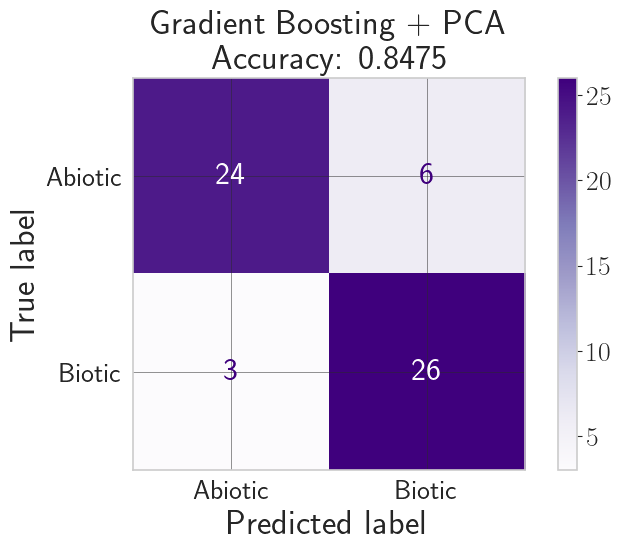

In [16]:
# Confusion Matrix for Gradient Boosting
fig, ax = plt.subplots(figsize=(8, 6))
cm_gb = confusion_matrix(y_test_encoded, y_pred_gb)
disp_gb = ConfusionMatrixDisplay(confusion_matrix=cm_gb, display_labels=le.classes_)
disp_gb.plot(cmap='Purples', ax=ax)
ax.set_title(f'Gradient Boosting + PCA\nAccuracy: {accuracy_score(y_test_encoded, y_pred_gb):.4f}')
plt.tight_layout()
plt.show()

### Model 5: K-Nearest Neighbors with PCA

In [17]:
# Model 5: KNN with PCA
param_grid_knn = {
    'pca__n_components': [5, 10, 20, 30, 50],
    'knn__n_neighbors': [1, 3, 5, 7, 9, 11, 15],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan', 'minkowski'],
    'knn__p': [1, 2, 3]  # Power parameter for Minkowski
}

pipeline_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('knn', KNeighborsClassifier())
])

grid_search_knn = GridSearchCV(pipeline_knn, param_grid_knn, cv=5, n_jobs=-1, scoring='balanced_accuracy', verbose=1)
grid_search_knn.fit(X_train, y_encoded)

best_knn = grid_search_knn.best_estimator_
y_pred_knn = best_knn.predict(X_test)

print(f"\n{'='*60}")
print("K-NEAREST NEIGHBORS WITH PCA")
print(f"{'='*60}")
print(f"Best CV Score: {grid_search_knn.best_score_:.4f}")
print(f"Best Parameters: {grid_search_knn.best_params_}")
print(f"\nTest Accuracy: {accuracy_score(y_test_encoded, y_pred_knn):.4f}")
print(f"Test F1 Score: {f1_score(y_test_encoded, y_pred_knn, average='weighted'):.4f}")
print(f"\nClassification Report:\n{classification_report(y_test_encoded, y_pred_knn, target_names=le.classes_)}")

Fitting 5 folds for each of 630 candidates, totalling 3150 fits

K-NEAREST NEIGHBORS WITH PCA
Best CV Score: 0.7364
Best Parameters: {'knn__metric': 'minkowski', 'knn__n_neighbors': 15, 'knn__p': 1, 'knn__weights': 'distance', 'pca__n_components': 50}

Test Accuracy: 0.7797
Test F1 Score: 0.7795

Classification Report:
              precision    recall  f1-score   support

     Abiotic       0.77      0.80      0.79        30
      Biotic       0.79      0.76      0.77        29

    accuracy                           0.78        59
   macro avg       0.78      0.78      0.78        59
weighted avg       0.78      0.78      0.78        59



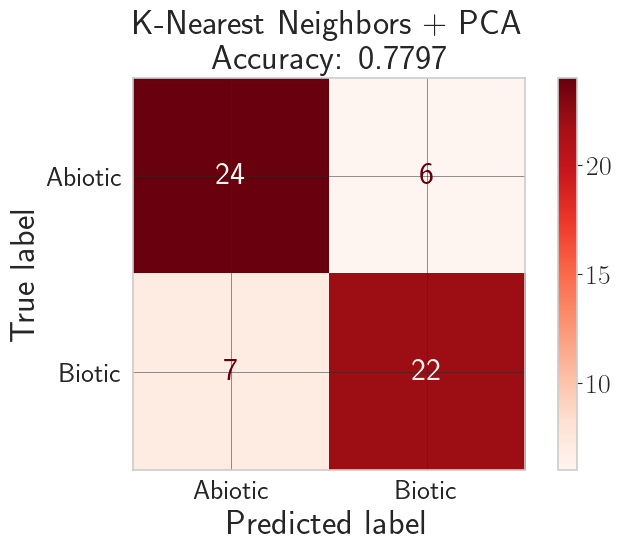

In [18]:
# Confusion Matrix for KNN
fig, ax = plt.subplots(figsize=(8, 6))
cm_knn = confusion_matrix(y_test_encoded, y_pred_knn)
disp_knn = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=le.classes_)
disp_knn.plot(cmap='Reds', ax=ax)
ax.set_title(f'K-Nearest Neighbors + PCA\nAccuracy: {accuracy_score(y_test_encoded, y_pred_knn):.4f}')
plt.tight_layout()
plt.show()

## Model Comparison Summary
Compare all models side by side to select the best one for Biotic vs Abiotic classification.

In [19]:
# Create comparison summary
results = {
    'Model': ['Logistic Regression', 'SVM', 'Random Forest', 'Gradient Boosting', 'KNN'],
    'CV Score': [
        grid_search_lr.best_score_,
        grid_search_svm.best_score_,
        grid_search_rf.best_score_,
        grid_search_gb.best_score_,
        grid_search_knn.best_score_
    ],
    'Test Accuracy': [
        accuracy_score(y_test_encoded, y_pred_lr),
        accuracy_score(y_test_encoded, y_pred_svm),
        accuracy_score(y_test_encoded, y_pred_rf),
        accuracy_score(y_test_encoded, y_pred_gb),
        accuracy_score(y_test_encoded, y_pred_knn)
    ],
    'Test F1 Score': [
        f1_score(y_test_encoded, y_pred_lr, average='weighted'),
        f1_score(y_test_encoded, y_pred_svm, average='weighted'),
        f1_score(y_test_encoded, y_pred_rf, average='weighted'),
        f1_score(y_test_encoded, y_pred_gb, average='weighted'),
        f1_score(y_test_encoded, y_pred_knn, average='weighted')
    ]
}

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Test F1 Score', ascending=False).reset_index(drop=True)
print("="*70)
print("MODEL COMPARISON - Biotic vs Abiotic Classification (Relative Change)")
print("="*70)
print(results_df.to_string(index=False))
print("\n" + "="*70)
print(f"BEST MODEL: {results_df.iloc[0]['Model']}")
print(f"Test Accuracy: {results_df.iloc[0]['Test Accuracy']:.4f}")
print(f"Test F1 Score: {results_df.iloc[0]['Test F1 Score']:.4f}")
print("="*70)

MODEL COMPARISON - Biotic vs Abiotic Classification (Relative Change)
              Model  CV Score  Test Accuracy  Test F1 Score
                SVM  0.771451       0.864407       0.864407
      Random Forest  0.796166       0.847458       0.847458
  Gradient Boosting  0.807088       0.847458       0.847194
Logistic Regression  0.769194       0.813559       0.813559
                KNN  0.736442       0.779661       0.779534

BEST MODEL: SVM
Test Accuracy: 0.8644
Test F1 Score: 0.8644


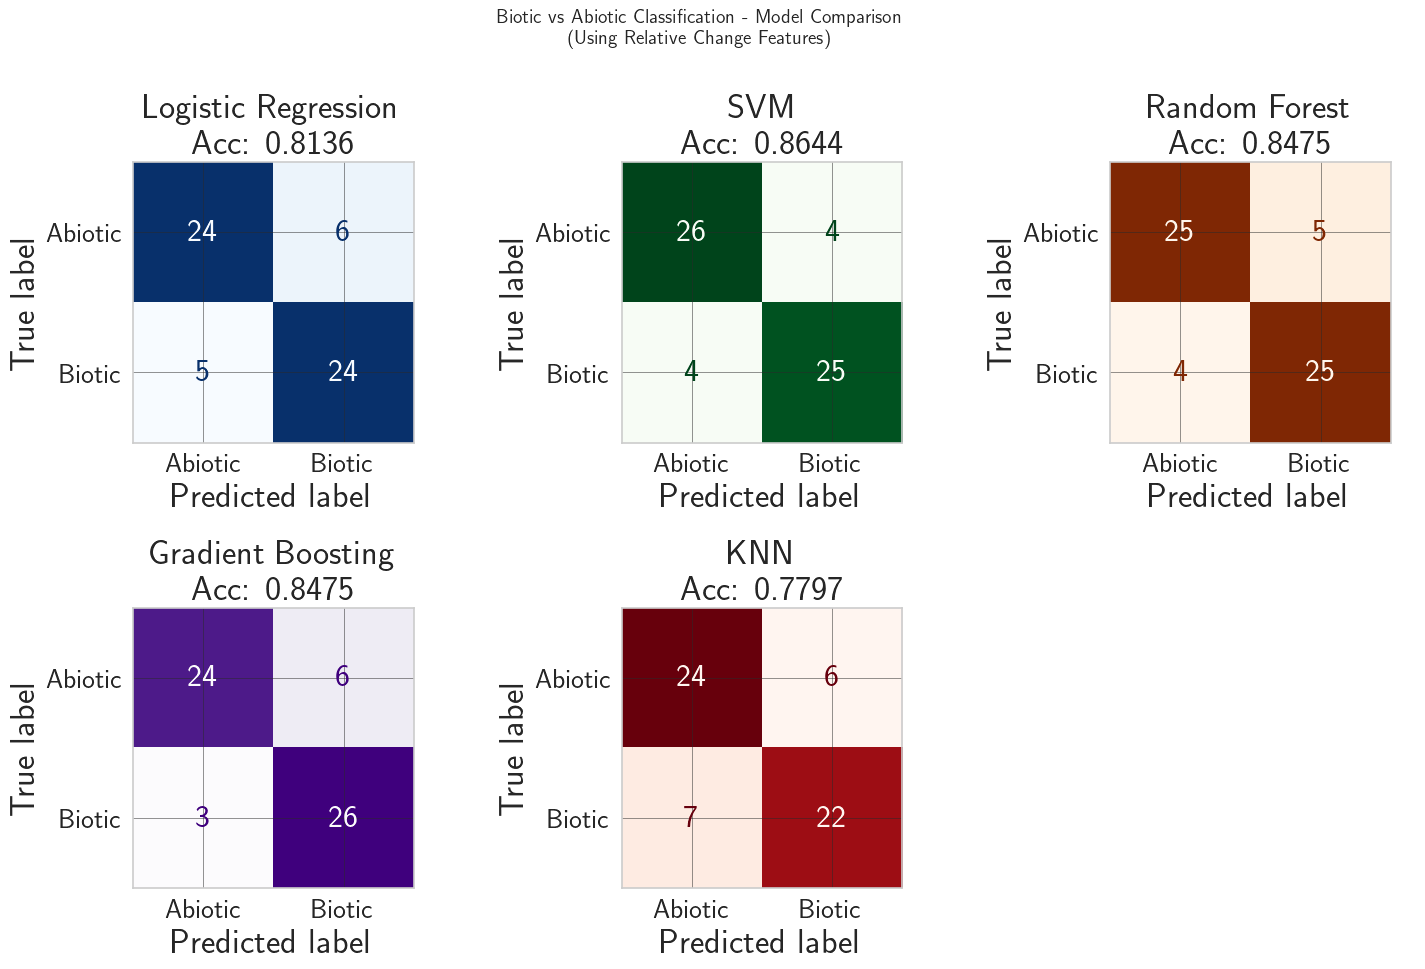

In [20]:
# Visual comparison of all models
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Plot all confusion matrices
models_data = [
    (cm_lr, 'Logistic Regression', 'Blues', y_pred_lr),
    (cm_svm, 'SVM', 'Greens', y_pred_svm),
    (cm_rf, 'Random Forest', 'Oranges', y_pred_rf),
    (cm_gb, 'Gradient Boosting', 'Purples', y_pred_gb),
    (cm_knn, 'KNN', 'Reds', y_pred_knn)
]

for idx, (cm, name, cmap, y_pred) in enumerate(models_data):
    ax = axes[idx // 3, idx % 3]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
    disp.plot(cmap=cmap, ax=ax, colorbar=False)
    acc = accuracy_score(y_test_encoded, y_pred)
    ax.set_title(f'{name}\nAcc: {acc:.4f}')

# Hide empty subplot
axes[1, 2].axis('off')

plt.suptitle('Biotic vs Abiotic Classification - Model Comparison\n(Using Relative Change Features)', fontsize=14)
plt.tight_layout()
plt.show()

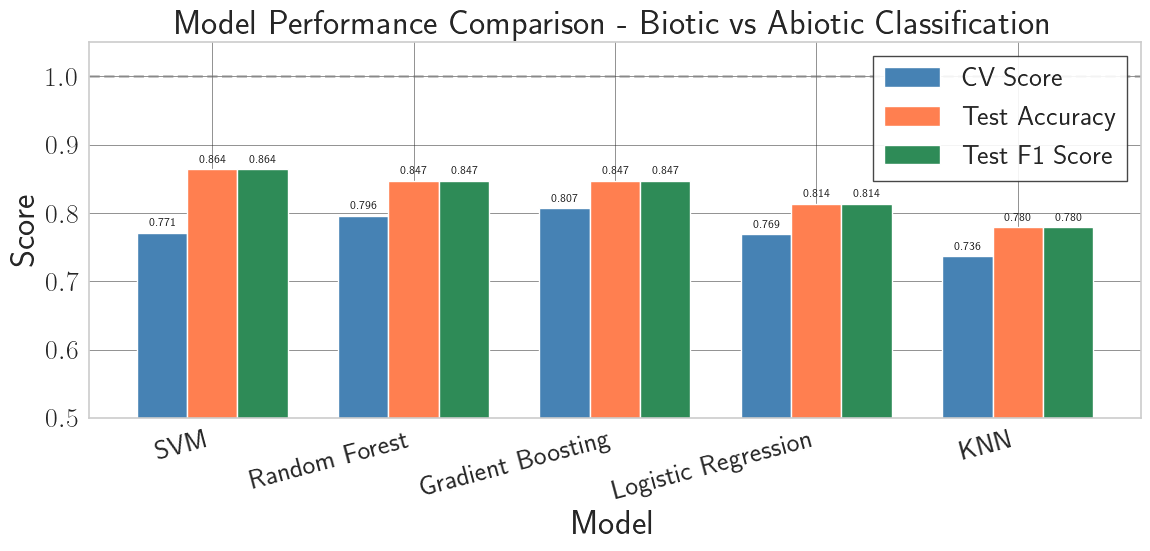

In [21]:
# Bar chart comparison
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(results_df))
width = 0.25

bars1 = ax.bar(x - width, results_df['CV Score'], width, label='CV Score', color='steelblue')
bars2 = ax.bar(x, results_df['Test Accuracy'], width, label='Test Accuracy', color='coral')
bars3 = ax.bar(x + width, results_df['Test F1 Score'], width, label='Test F1 Score', color='seagreen')

ax.set_xlabel('Model')
ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison - Biotic vs Abiotic Classification')
ax.set_xticks(x)
ax.set_xticklabels(results_df['Model'], rotation=15, ha='right')
ax.legend()
ax.set_ylim([0.5, 1.05])
ax.axhline(y=1.0, color='gray', linestyle='--', alpha=0.5)

# Add value labels on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

## Optional: SMOTE for Class Balancing (If needed)
If the class distribution is imbalanced, use SMOTE to generate synthetic samples.

In [22]:
# Check class balance
print("Class distribution in training set:")
unique, counts = np.unique(y_encoded, return_counts=True)
for cls, count in zip(le.classes_, counts):
    print(f"  {cls}: {count} ({count/len(y_encoded)*100:.1f}%)")

# Apply SMOTE if imbalanced (uncomment if needed)
imbalance_ratio = min(counts) / max(counts)
print(f"\nImbalance ratio: {imbalance_ratio:.3f}")

if imbalance_ratio < 0.5:
    print("\n⚠️ Class imbalance detected! Applying SMOTE...")
    smote = SMOTE(random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_encoded)
    print(f"After SMOTE: {np.unique(y_train_balanced, return_counts=True)}")
else:
    print("\n✅ Classes are reasonably balanced. SMOTE not necessary.")
    X_train_balanced, y_train_balanced = X_train, y_encoded

Class distribution in training set:
  Abiotic: 849 (50.9%)
  Biotic: 820 (49.1%)

Imbalance ratio: 0.966

✅ Classes are reasonably balanced. SMOTE not necessary.


## Save Best Model and Results

In [23]:
# Save results to CSV
results_df.to_csv('biotic_abiotic_model_comparison.csv', index=False)
print("Results saved to 'biotic_abiotic_model_comparison.csv'")

# Save best model parameters
best_models = {
    'Logistic Regression': grid_search_lr.best_params_,
    'SVM': grid_search_svm.best_params_,
    'Random Forest': grid_search_rf.best_params_,
    'Gradient Boosting': grid_search_gb.best_params_,
    'KNN': grid_search_knn.best_params_
}

import json
with open('best_model_parameters.json', 'w') as f:
    json.dump(best_models, f, indent=4)
print("Best parameters saved to 'best_model_parameters.json'")

# Identify the best overall model
best_model_name = results_df.iloc[0]['Model']
print(f"\n🏆 Recommended model: {best_model_name}")

Results saved to 'biotic_abiotic_model_comparison.csv'
Best parameters saved to 'best_model_parameters.json'

🏆 Recommended model: SVM
